# Import Libraries

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# Set Parameters

In [2]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Load Data from Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Define base data directory in Google Drive
data_dir = '/content/drive/MyDrive/Colab Notebooks/chest_xray'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

Mounted at /content/drive


# Helper Function to Load Paths and Labels

In [4]:
def load_paths_labels(directory, set_name):
    filepaths = []
    labels = []
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                filepaths.append(os.path.join(folder_path, file))
                labels.append(folder)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    set_series = pd.Series([set_name] * len(filepaths), name='set')
    return pd.concat([Fseries, Lseries, set_series], axis=1)

# Load Train, Validation, and Test Data into DataFrames

In [5]:
train_df = load_paths_labels(train_dir, 'train')
val_df = load_paths_labels(val_dir, 'val')
test_df = load_paths_labels(test_dir, 'test')

# Data Generators with Image Augmentation

In [6]:
tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen = tr_gen.flow_from_dataframe(
    train_df, x_col='filepaths', y_col='labels', target_size=img_size,
    class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(
    val_df, x_col='filepaths', y_col='labels', target_size=img_size,
    class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(
    test_df, x_col='filepaths', y_col='labels', target_size=img_size,
    class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

# Class indices for reference
g_dict = train_gen.class_indices
class_count = len(g_dict)

Found 4740 validated image filenames belonging to 2 classes.
Found 492 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


# Show Sample from Train Data

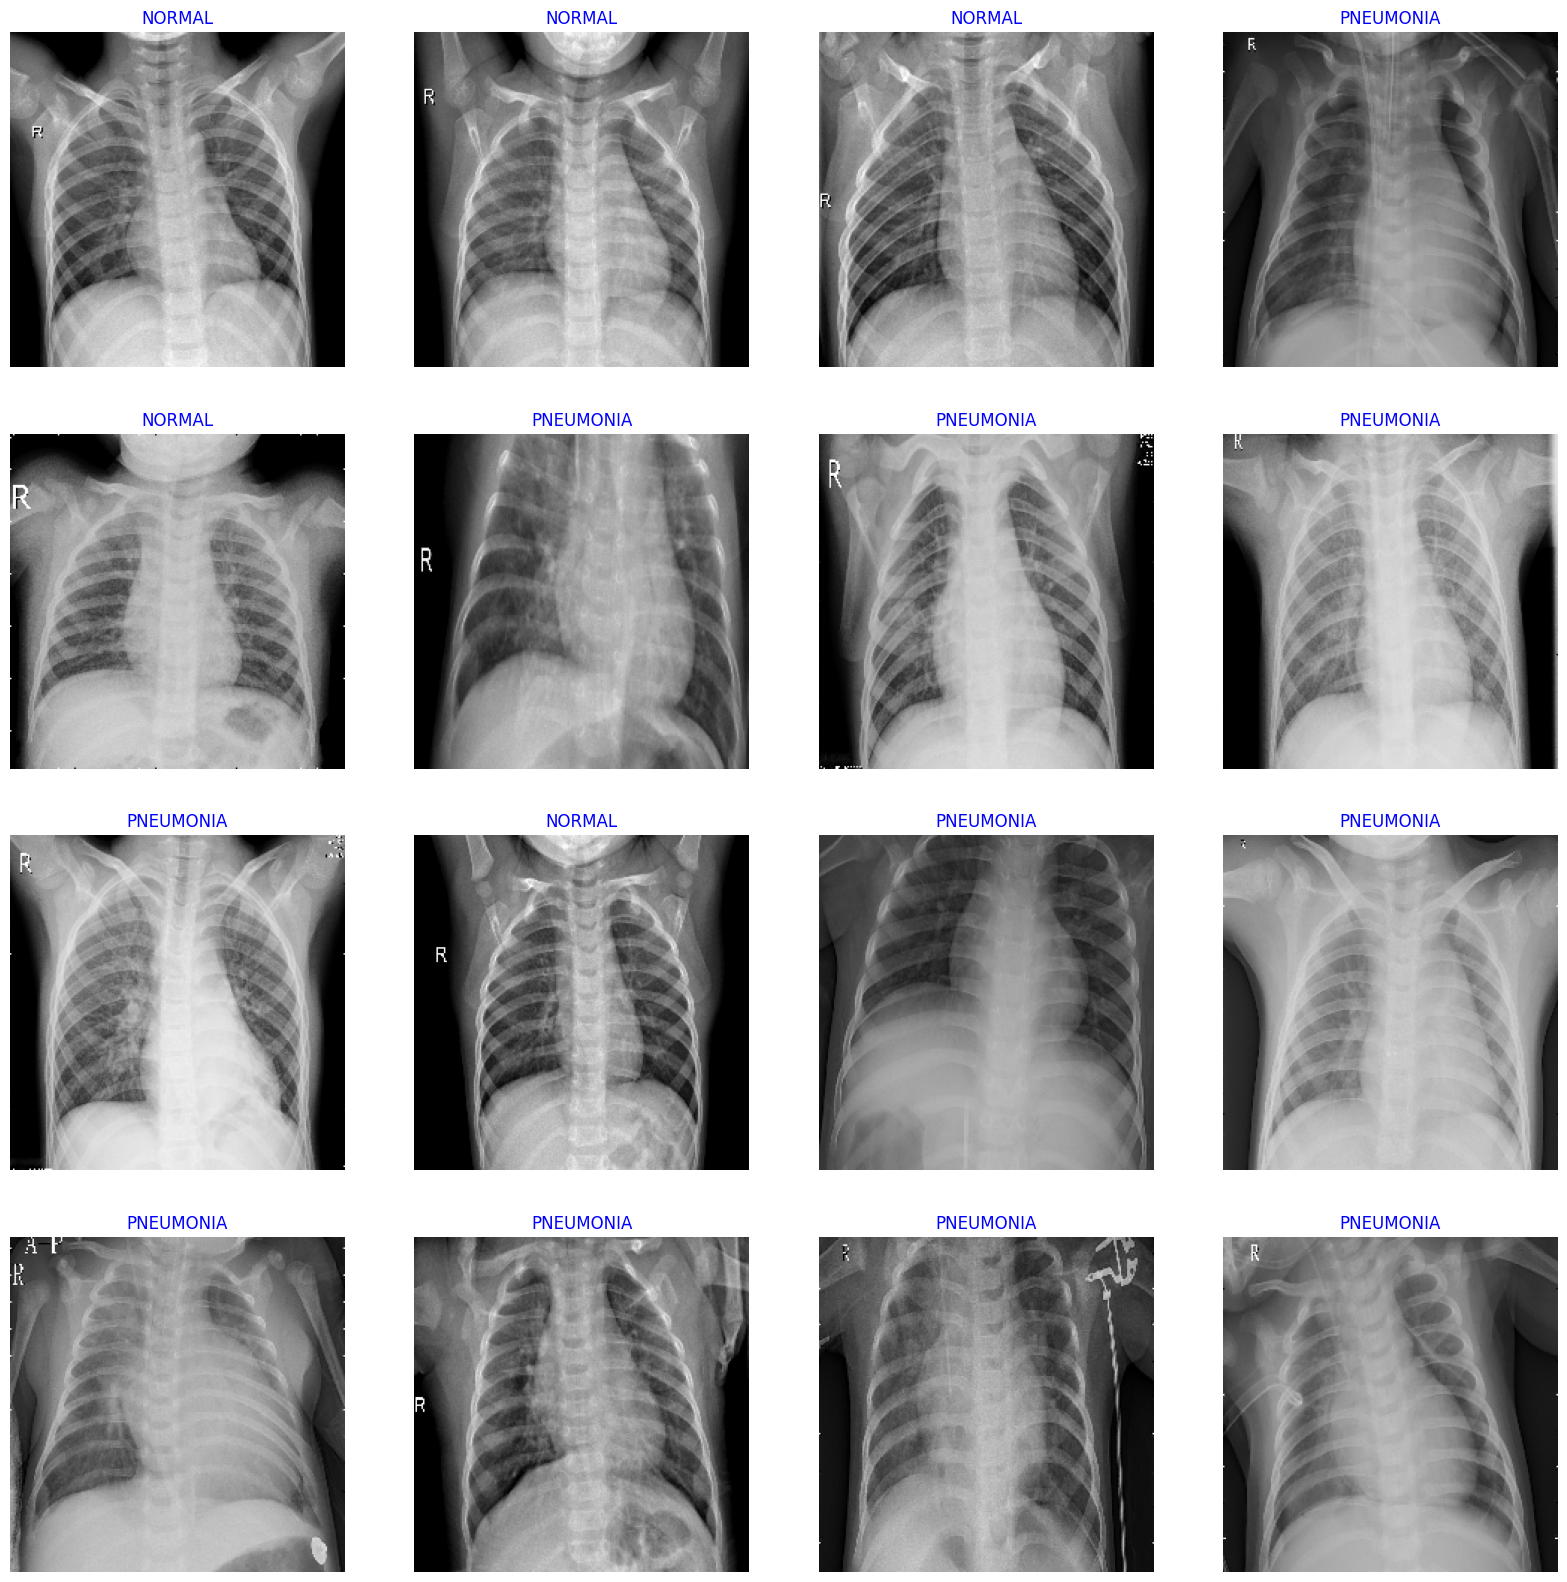

In [8]:
classes = list(g_dict.keys())     # Defines list of class names

# Retrieve a batch of images and labels from the generator
images, labels = next(train_gen)  # Get a batch of images and corresponding labels

# Plot the images
plt.figure(figsize=(20, 20))
for i in range(16):  # Display first 16 images
    plt.subplot(4, 4, i + 1)
    image = images[i]  # Images are already scaled to [0, 1]
    plt.imshow(image)
    index = np.argmax(labels[i])  # Find the class index from the one-hot encoded labels
    class_name = classes[index]   # Map the index to the class name
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()


# Build VGG16 Model

In [ ]:
base_model = VGG16(include_top=False, weights="imagenet", input_shape=img_shape)
base_model.trainable = False

model_vgg16 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006),
          activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

# Compile model
model_vgg16.compile(optimizer=Adamax(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Model Summary
model_vgg16.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                         

# Train the Model

In [ ]:
epochs = 10
start_time = time.time()
history_vgg16 = model_vgg16.fit(
    train_gen, epochs=epochs, validation_data=valid_gen, shuffle=False
)
end_time = time.time()
print(f"Total training time for {epochs} epochs: {end_time - start_time:.2f} seconds")

Epoch 1/10
297/297 [==============================] - 572s 2s/step - loss: 2.5445 - accuracy: 0.9245 - val_loss: 1.4959 - val_accuracy: 0.8537
Epoch 2/10
297/297 [==============================] - 285s 958ms/step - loss: 0.9689 - accuracy: 0.9565 - val_loss: 0.7356 - val_accuracy: 0.9472
Epoch 3/10
297/297 [==============================] - 286s 962ms/step - loss: 0.5658 - accuracy: 0.9624 - val_loss: 0.4795 - val_accuracy: 0.9593
Epoch 4/10
297/297 [==============================] - 286s 962ms/step - loss: 0.3937 - accuracy: 0.9671 - val_loss: 0.3576 - val_accuracy: 0.9634
Epoch 5/10
297/297 [==============================] - 284s 957ms/step - loss: 0.3060 - accuracy: 0.9726 - val_loss: 0.2893 - val_accuracy: 0.9614
Epoch 6/10
297/297 [==============================] - 284s 955ms/step - loss: 0.2549 - accuracy: 0.9692 - val_loss: 0.2447 - val_accuracy: 0.9654
Epoch 7/10
297/297 [==============================] - 285s 959ms/step - loss: 0.2247 - accuracy: 0.9700 - val_loss: 0.2457 - va

# Evaluate the Model

In [ ]:
train_score_vgg16 = model_vgg16.evaluate(train_gen, verbose=1)
valid_score_vgg16 = model_vgg16.evaluate(valid_gen, verbose=1)
test_score_vgg16 = model_vgg16.evaluate(test_gen, verbose=1)

print("VGG16 Model Results")
print("Train Loss:", train_score_vgg16[0], "Train Accuracy:", train_score_vgg16[1])
print("Validation Loss:", valid_score_vgg16[0], "Validation Accuracy:", valid_score_vgg16[1])
print("Test Loss:", test_score_vgg16[0], "Test Accuracy:", test_score_vgg16[1])

39/39 [==============================] - 154s 4s/step - loss: 0.6360 - accuracy: 0.7981
VGG16 Model Results
Train Loss: 0.14522024989128113 Train Accuracy: 0.9867088794708252
Validation Loss: 0.19424203038215637 Validation Accuracy: 0.9634146094322205
Test Loss: 0.6359667181968689 Test Accuracy: 0.7980769276618958


# Plot Accuracy and Loss

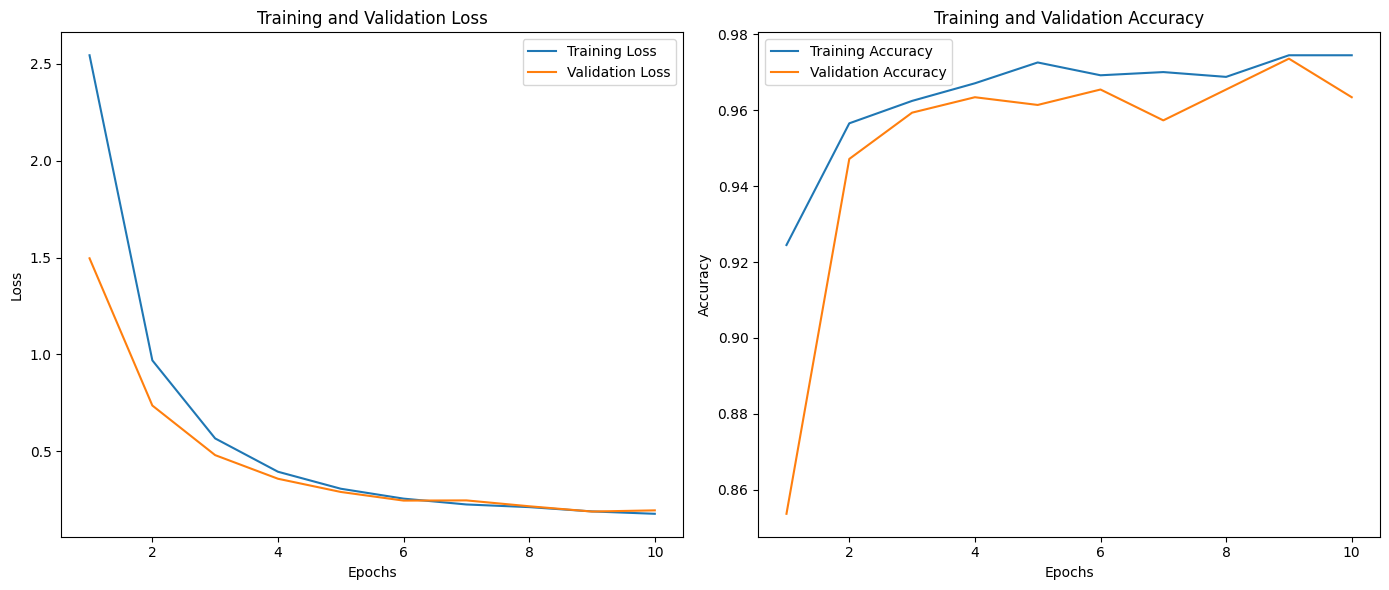

In [ ]:
tr_acc_vgg16 = history_vgg16.history['accuracy']
tr_loss_vgg16 = history_vgg16.history['loss']
val_acc_vgg16 = history_vgg16.history['val_accuracy']
val_loss_vgg16 = history_vgg16.history['val_loss']
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, tr_loss_vgg16, label="Training Loss")
plt.plot(epochs_range, val_loss_vgg16, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, tr_acc_vgg16, label="Training Accuracy")
plt.plot(epochs_range, val_acc_vgg16, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

plt.tight_layout()
plt.show()

# Predictions and Confusion Matrix

39/39 [==============================] - 34s 853ms/step


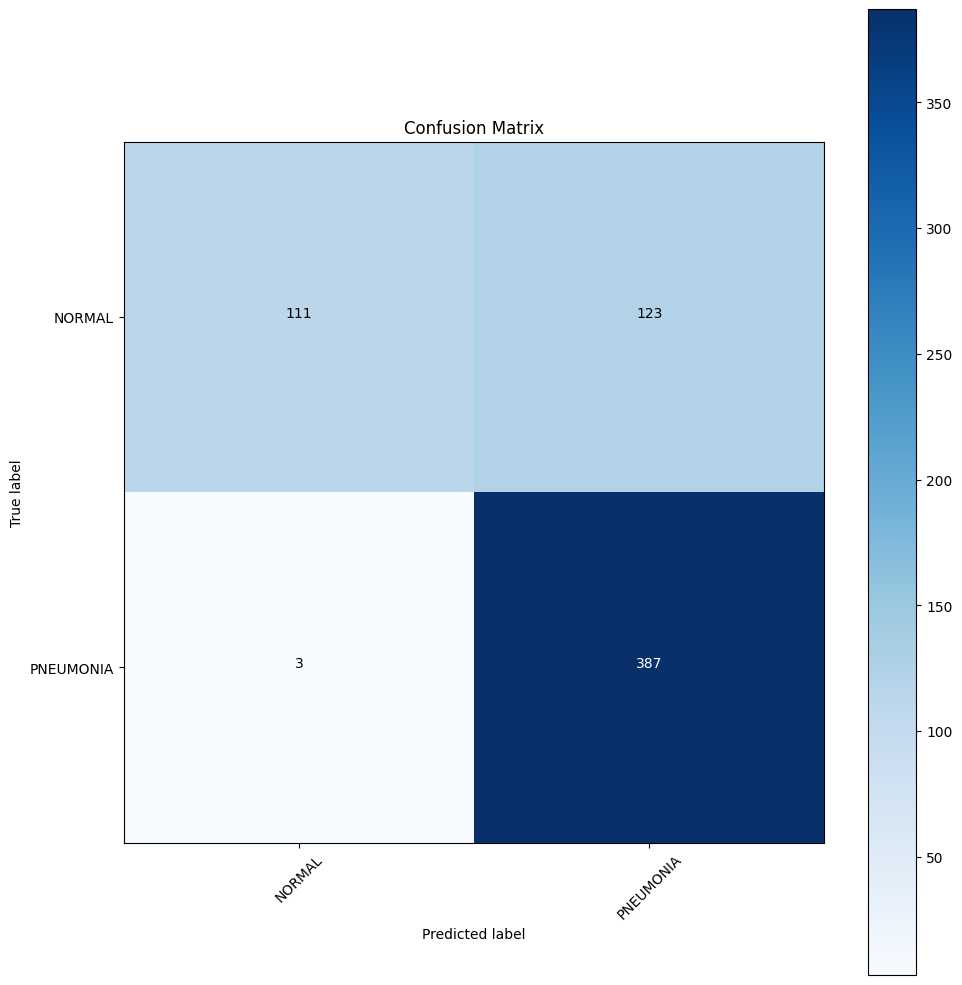

In [ ]:
preds = model_vgg16.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

cm = confusion_matrix(test_gen.classes, y_pred)
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(g_dict))
plt.xticks(tick_marks, g_dict.keys(), rotation=45)
plt.yticks(tick_marks, g_dict.keys())

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Classification Report

In [ ]:
print(classification_report(test_gen.classes, y_pred, target_names=g_dict.keys()))

              precision    recall  f1-score   support

      NORMAL       0.97      0.47      0.64       234
   PNEUMONIA       0.76      0.99      0.86       390

    accuracy                           0.80       624
   macro avg       0.87      0.73      0.75       624
weighted avg       0.84      0.80      0.78       624

